# Autoencoders in de-noising images
##### Autoencoders are very useful in de-noising images

### mounting drive and importing data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### unzipping file

In [2]:
from zipfile import ZipFile

archive = ZipFile('/content/drive/MyDrive/denoising-dirty-documents.zip')
archive.extractall('/content')

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# created a new folder called workpath
os.mkdir('/content/workpath/')
path='/content/workpath/'


In [5]:
# extracting the required zipped files into the workpath folder
archive = ZipFile('/content/train.zip')
archive.extractall('/content/workpath')

archive = ZipFile('/content/train_cleaned.zip')
archive.extractall('/content/workpath')

archive = ZipFile('/content/test.zip')
archive.extractall('/content/workpath')

### storing the img names into a list

In [6]:
train_img=sorted(os.listdir('/content/workpath/train'))
train_cleaned_img=sorted(os.listdir('/content/workpath/train_cleaned'))
test_img=sorted(os.listdir('/content/workpath/test'))

In [7]:
print(train_img)

['101.png', '102.png', '104.png', '105.png', '107.png', '108.png', '11.png', '110.png', '111.png', '113.png', '114.png', '116.png', '117.png', '119.png', '12.png', '120.png', '122.png', '123.png', '125.png', '126.png', '128.png', '129.png', '131.png', '132.png', '134.png', '135.png', '137.png', '138.png', '14.png', '140.png', '141.png', '143.png', '144.png', '146.png', '147.png', '149.png', '15.png', '150.png', '152.png', '153.png', '155.png', '156.png', '158.png', '159.png', '161.png', '162.png', '164.png', '165.png', '167.png', '168.png', '17.png', '170.png', '171.png', '173.png', '174.png', '176.png', '177.png', '179.png', '18.png', '180.png', '182.png', '183.png', '185.png', '186.png', '188.png', '189.png', '191.png', '192.png', '194.png', '195.png', '197.png', '198.png', '2.png', '20.png', '200.png', '201.png', '203.png', '204.png', '206.png', '207.png', '209.png', '21.png', '210.png', '212.png', '213.png', '215.png', '216.png', '23.png', '24.png', '26.png', '27.png', '29.png', '3

## Data processing
##### Apparently, Colab keeps on crashing due to the size of the input images. The solution will be to resize the images into smaller pixel sizes.

In [8]:
# create a processing function
# this function reads the images,converts the images into numpy arrays, resizes the image into a 540 by 540 pixel size. It also converts the images into grayscale.
def img_processing(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (200, 200))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, ( 200,200, 1))
    
    return img



In [9]:
# defining the input shape:
input_shape=(200,200,1)

In [10]:
# processing of the images and storing them inside empty lists

train=[]
train_cleaned=[]
test=[]

for i in train_img:
  train.append(img_processing(path +'/train/'+ i))

for i in train_cleaned_img:
  train_cleaned.append(img_processing(path + '/train_cleaned/'+ i))

for i in test_img:
  test.append(img_processing(path +'/test/'+i))

## EDA
### A glimpse of the dirty image and its clean image alongside it
### These images are going to be fed into the model in order for the model to learn how to clean noise from the background.

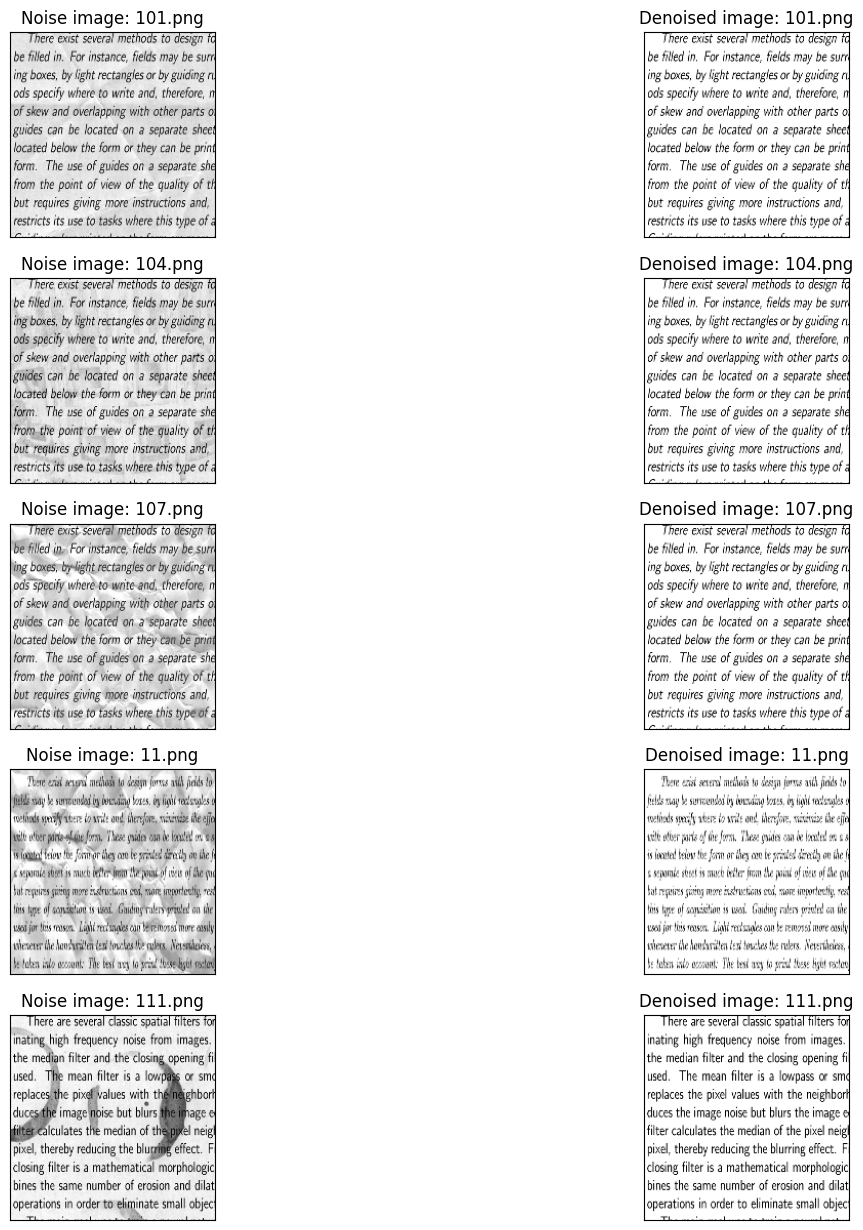

In [11]:
plt.figure(figsize=(15,25))
for i in range(0,10,2):
    plt.subplot(8,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(8,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

### Splitting data

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# converting the list into numpy array and separating them into independent and dependent variable
# the 'train' data is the x variable while the 'train_cleaned' is the y variable

x_train= np.asarray(train)
y_train= np.asarray(train_cleaned)
x_test= np.asarray(test)

# not wanting to use all the training data, i am going to split it into training and validation data

x_train, x_val, y_train, y_val= train_test_split(x_train,y_train,test_size=0.2)

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping


In [15]:
# i may add more layers
def model(): 
  input_layer= Input(shape=input_shape,name='encoder_input')

  # encoding layer(compression)
  x= Conv2D( 64,(3,3), padding='same',activation='relu')(input_layer)
  x=Conv2D(128,(3,3),activation='relu',padding='same')(x)
  x=BatchNormalization()(x)
  x=MaxPooling2D((2,2),padding='same')(x)
  x=Dropout(0.5)(x)

  #decoding layer (expansion)
  x= Conv2D(128,(3,3),activation='relu',padding='same')(x)
  x= Conv2D(64,(3,3),activation='relu',padding='same')(x)
  x= BatchNormalization()(x)
  x=UpSampling2D((2,2))(x)

  output_layer=Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)
  model = Model(inputs=[input_layer], outputs=[output_layer])

  #compile the model
  model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])

  return model

model=model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 128)     73856     
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 128)     0     

In [20]:
callback=EarlyStopping( monitor='loss',patience=30)
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=400,batch_size=64,verbose=0,callbacks=[callback])

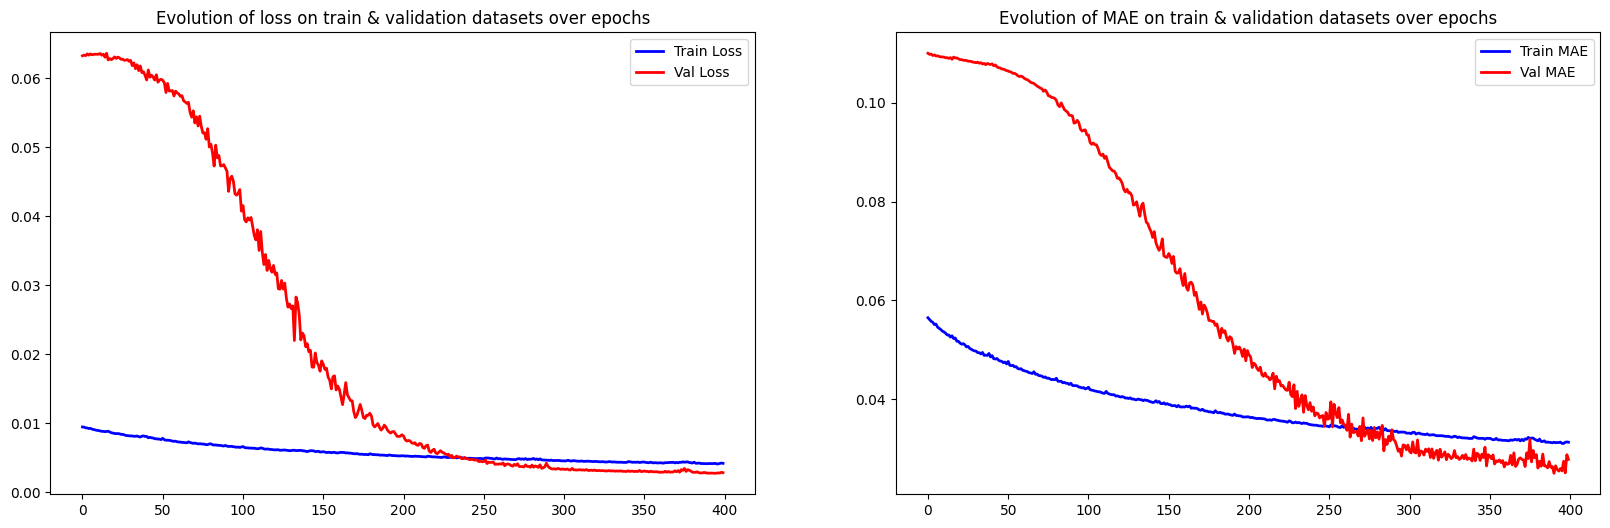

In [21]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

### Testing the model by cleaning some test images 

In [22]:
# predict/clean test images
y_test = model.predict(x_test, batch_size=16)

5/5 [==============================] - 0s 45ms/step


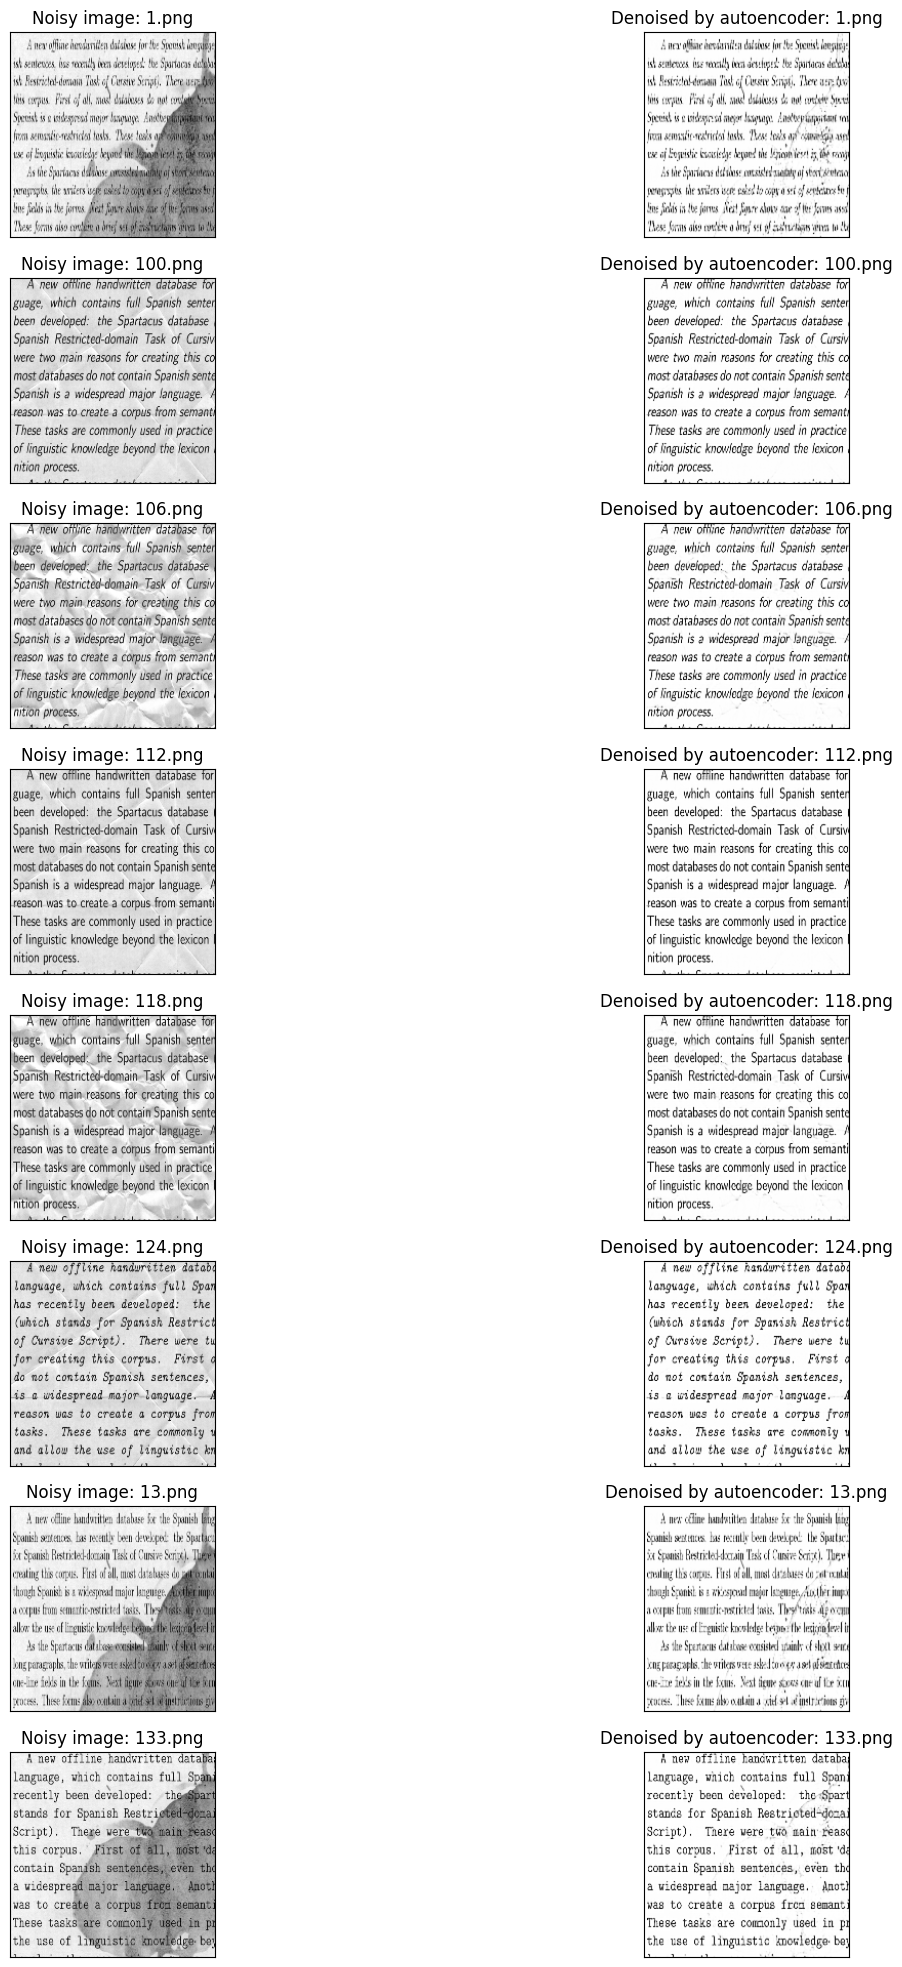

In [23]:
plt.figure(figsize=(15,25))
for i in range(0,16,2):
    plt.subplot(8,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(8,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

### From this test we can see how well the model was able to denoise the images